In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
from pyfonts import load_font

## Get data

In [2]:
df = pd.read_csv("data//activities.csv")

In [3]:
#dataset checks ----------------------
columns = df.columns
expected_columns = ['Activity ID', 'Activity Date', 'Activity Name', 'Activity Type', 'Distance.1', 'Moving Time']
missing_columns = []
flag = False

for column in expected_columns:
    if column not in columns:
        flag=True
        missing_columns.append(column)

if flag==True:
    print("Your dataset looks off")
    print("----")
    print("The dataset is missing the following columns: " + str(missing_columns))
    print("Check that the dataset matches the expected format outlined here")

## Analyse and prepare data

In [4]:
#reduce to relevant columns
df = df[expected_columns].rename(columns={"Distance.1":"Distance"})

#convert date column into datetime
df["Activity Date"] = pd.to_datetime(df["Activity Date"])

In [40]:
#inputs -----------------------

#set filter
year_filter = 2024

#set aggregation method
agg_method = "Counts"

#set distance unit
distance_unit = "km"

#data prep -----------------------

#filter for 1 year
df_filtered = df[df["Activity Date"].dt.year == year_filter]

#get max top 3 activity types for aggregation method
if agg_method in ["Moving time", "Distance"]:
    top_three = df_filtered.groupby(["Activity Type"]
                                    )[agg_method].sum().sort_values(
                                    ascending=False).head(3).index.to_list()
else:
    top_three = df_filtered["Activity Type"].value_counts().head(3).index.to_list()

#derive clean column for activity types to use later
df_filtered["Activity Type clean"] = [activity if activity in top_three else "Other"
                                        for activity in df_filtered['Activity Type']]
df_filtered["Activity rank"] = df_filtered["Activity Type"].map(
    dict(zip(top_three, np.arange(0,len(top_three),1)))
    ).fillna(len(top_three))

C:\Users\lisa.hornung\AppData\Local\Temp\ipykernel_25000\948914127.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Activity Type clean"] = [activity if activity in top_three else "Other"
C:\Users\lisa.hornung\AppData\Local\Temp\ipykernel_25000\948914127.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered["Activity rank"] = df_filtered["Activity Type"].map(


In [ ]:
#pre-aggregate data---------------------------
#for daily circles
pivot = df_filtered.groupby([df_filtered["Activity Date"].dt.month,
                             df_filtered["Activity Date"].dt.day]).agg({'Activity Type clean': ','.join})
pivot.index.names = ["Month", "Day"]
pivot = pivot.reset_index()
pivot["Activity Type clean"] = [i.split(",") for i in pivot["Activity Type clean"]]

#top three df
top_three_df = df_filtered[["Activity rank","Activity Type clean"]].value_counts().to_frame().reset_index().sort_values(by="Activity rank")

#for small multiples
months = np.arange(1,13,1)
time_values = []
distance_values = []
for month in months:
    time_values.append(df_filtered[(df_filtered["Activity Date"].dt.month == month)]["Moving Time"].sum())
    if distance_unit=="km":
        distance_values.append(df_filtered[(df_filtered["Activity Date"].dt.month == month)]["Distance"].sum()/1000)
    elif distance_unit=="m":
        distance_values.append(df_filtered[(df_filtered["Activity Date"].dt.month == month)]["Distance"].sum()/1600)

#helper calculations for final visuals --------------------
#calculate dynamic axis ticks based on max time per month
def get_axis_ticks(max_sec):
    n_ticks=4
    if round(max_sec/n_ticks/60/60)>0:
        steps = 60*60*(round(max_sec/n_ticks/60/60))
    elif round(max_sec/n_ticks/60)>0:
        steps = 60*(round(max_sec/6/60))
    else:
        steps = n_ticks
    return steps

#convert seconds into nice format on chart
def convert_time(sec):
   hour = sec // 3600
   sec %= 3600
   min = sec // 60
   sec %= 60
   return "%02d:%02d" % (hour, min) 

## Visualise

In [89]:
#configs for visual-----------------------

#load fonts
font_b = load_font(font_url='https://github.com/andrew-paglinawan/QuicksandFamily/blob/master/fonts/statics/Quicksand-Bold.ttf?raw=true')
font_r = load_font(font_url='https://github.com/andrew-paglinawan/QuicksandFamily/blob/master/fonts/statics/Quicksand-Regular.ttf?raw=true')
font_m = load_font(font_url='https://github.com/andrew-paglinawan/QuicksandFamily/blob/master/fonts/statics/Quicksand-Medium.ttf?raw=true')

#create colour dict for activities
act_color = ["#6DB4C8", "#FD7B5C", "#FBCA58", "#7E8384"]
act_colormap = dict(zip(top_three + ["Other"], act_color))

#colors
colors = {"bg": "#FDFBF7", "text":"#2E3234", "bars":"#C6C9CA"}

#basesize of circles
markersize = 80

#axis labels
month_labels = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']

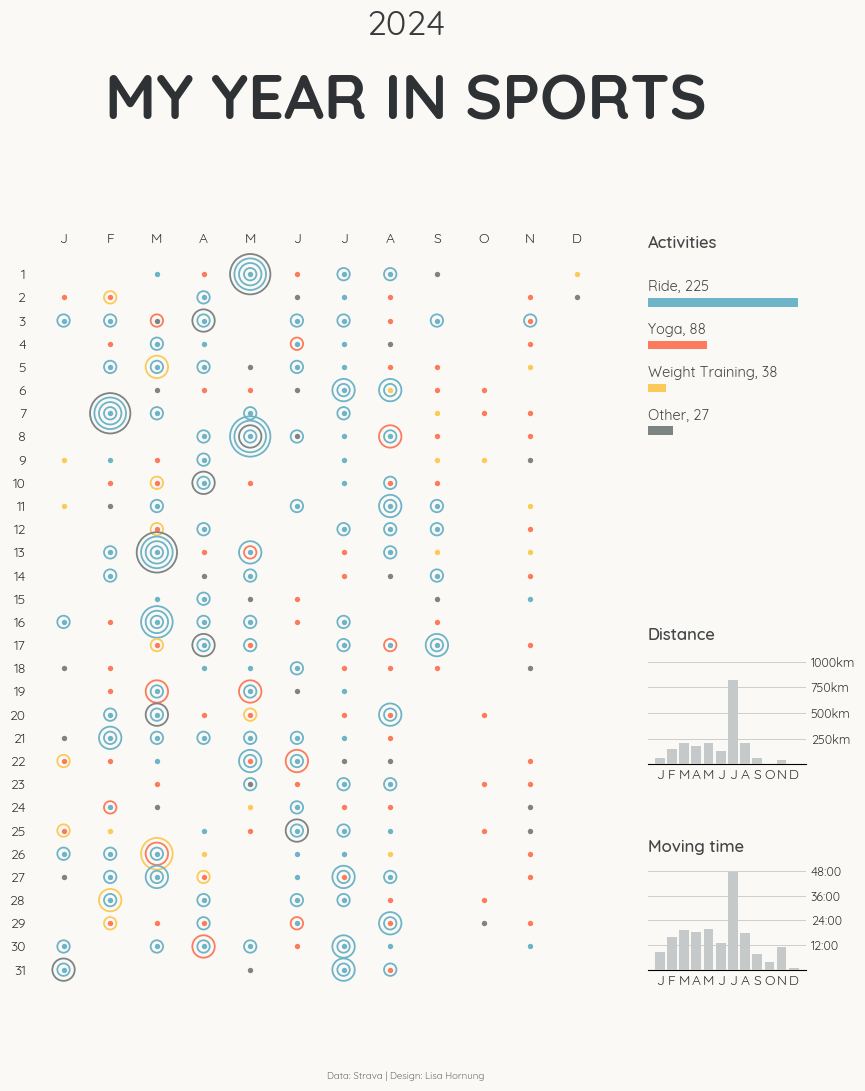

In [96]:
#setup fig-------------------------------
fig = plt.figure(figsize=(10,12))
fig.set_facecolor(colors["bg"])
gs = GridSpec(5, 4, figure=fig)
ax1 = fig.add_subplot(gs[0:4, 0:3])
ax2 = fig.add_subplot(gs[2:3:, 3:])
ax3 = fig.add_subplot(gs[3:4:, 3:])
plt.subplots_adjust(hspace=1, wspace=0.3)
for ax in [ax1, ax2, ax3]:
    ax.set_facecolor(colors["bg"])

#plot data -----------
#circles
for row in range(len(pivot)):
    for i,label in enumerate(pivot.loc[row]["Activity Type clean"]):
        if i==0:
            ax1.scatter(x=pivot.loc[row]["Month"],
                  y=pivot.loc[row]["Day"],
                  s=15,
                  linewidth=0,
                  color=act_colormap[label],
                  clip_on=False)
        else:
            ax1.scatter(x=pivot.loc[row]["Month"],
                  y=pivot.loc[row]["Day"],
                  s=(i**1.7)*markersize,
                  color="None",
                  edgecolor=act_colormap[label],
                  linewidth=1.3,
                  clip_on=False)
            
#bar charts
ax2.bar(months, distance_values, color=colors["bars"], zorder=3)
ax3.bar(months, time_values, color=colors["bars"], zorder=3)
            
#format axis------------------
#circles
ax1.set_xticks(np.arange(1,13,1))
ax1.set_yticks(np.arange(1,32,1))
ax1.tick_params(axis="both", length=0, labeltop=True, labelbottom=False,)
ax1.set_yticklabels(labels=ax1.get_yticks(), fontproperties=font_r, fontsize=10, color=colors["text"])
ax1.set_xticklabels(labels=month_labels, fontproperties=font_r, fontsize=10,color=colors["text"])
ax1.set_xlim(xmin=0.3,xmax=12.5)
ax1.set_ylim(ymin=0,ymax=31)
ax1.invert_yaxis()
for pos in ["top", "bottom", "left", "right"]:
    ax1.spines[pos].set_visible(False)

#barcharts
for ax in [ax2, ax3]:
    ax.set_xticks(np.arange(1,13,1))
    ax.set_xticklabels(labels=month_labels, fontproperties=font_r, fontsize=10,color=colors["text"])
    ax.tick_params(axis="both", length=0,labelleft=False, labelright=True,)
    ax.grid(visible="True", axis='y', zorder=1, color=colors["text"], alpha=0.3, linewidth=0.5)
    for pos in ["top", "left", "right"]:
        ax.spines[pos].set_visible(False)

#distance
ax2.locator_params(axis='y', nbins=4)
ax2.set_yticks(ax2.get_yticks())
ax2.set_yticklabels([""]+["{}{}".format(i.astype(int),distance_unit) for i in ax2.get_yticks()][1:],fontproperties=font_r, fontsize=9,color=colors["text"])
ax2.text(0,ax2.get_yticks()[-1]+ax2.get_yticks()[1], "Distance", fontsize=12, ha="left", va="center", fontproperties=font_m, color=colors["text"], alpha=0.9)

#total time
tick_steps = get_axis_ticks(max(time_values))
ax3.set_yticks(np.arange(0, max(time_values)+tick_steps, tick_steps))
ax3.set_yticklabels([""]+[convert_time(i) for i in ax3.get_yticks()][1:],fontproperties=font_r, fontsize=9,color=colors["text"])
ax3.text(0,max(time_values)+tick_steps, "Moving time", fontsize=12, ha="left", va="center", fontproperties=font_m, color=colors["text"], alpha=0.9)

#legend--------------------------------
lg = fig.add_subplot(gs[0:2:, 3:])
labels = top_three_df["Activity Type clean"].to_list()
lg.barh(top_three_df["Activity rank"], top_three_df["count"], height=0.2, color=top_three_df["Activity Type clean"].map(act_colormap))
lg.set_ylim(ymin=-1.2,ymax=6)
lg.invert_yaxis()
lg.text(0, lg.get_ylim()[1], "Activities", fontsize=12, ha="left", va="bottom", fontproperties=font_m, color=colors["text"], alpha=0.9)
for i in range(len(top_three_df)):
    lg.text(0.1, i-0.35, labels[i]+", "+str( top_three_df["count"][i]), fontsize=10.5, ha="left", va="center", fontproperties=font_r, color=colors["text"], alpha=0.9)
lg.axis("off")

#header and footer------------------------
plt.figtext(0.5,0.99,'My year in sports'.upper(), 
            ha="center",
            fontsize = 45, 
            color=colors["text"], 
            fontproperties=font_b)
plt.figtext(0.5,1.06,'{}'.format(year_filter), ha="center",fontsize = 25, color=colors["text"], alpha=0.95, fontproperties=font_r)
plt.figtext(0.5,0.19,'Data: Strava | Design: Lisa Hornung',ha="center", fontsize = 7, color=colors["text"], alpha=0.7,fontproperties=font_r)

#save output-------------------------------
plt.savefig("my-year-in-sports-{}.png".format(year_filter), dpi=300, bbox_inches="tight", pad_inches=0.8)
plt.savefig("my-year-in-sports-{}.svg".format(year_filter))

plt.show()

(0.0, 1.0, 3.0, -0.8)

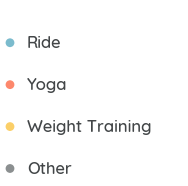

In [ ]:
# OLD LEGEND
fig = plt.figure(figsize=(10,12))
gs = GridSpec(5, 4, figure=fig)

#old legend
lg = fig.add_subplot(gs[0:1:, 3:])
kw = dict(marker='o', s=40, alpha=0.9, linewidths=0)
labels = df_filtered[["Activity Type clean", "Activity rank"]].drop_duplicates(
    ).sort_values(by="Activity rank")["Activity Type clean"].to_list()
len_act = df_filtered["Activity rank"].max().astype(int)+1
lg.scatter(y=np.arange(0,len_act,1), 
           x=[0]*len_act, color=[act_colormap[label] for label in labels], **kw, clip_on=False)
lg.set_xlim(xmin=0,xmax=1)
lg.set_ylim(ymin=-0.8,ymax=3)
lg.invert_yaxis()
for i, y_pos in enumerate(np.arange(0,len_act,1)):
    lg.text(0.1, y_pos, labels[i], fontsize=12, ha="left", va="center", fontproperties=font_m, color=colors["text"], alpha=0.9)
lg.axis("off")